In [20]:
%load_ext autoreload
%autoreload 2

import os
import importlib
import gc

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import minimize
import scipy.io

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px


import localtool.databackup as lback
import localtool.operator as loper
import localtool.predictor as lpred
import localtool.visualizer as lvisu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. Data preparation

In [ ]:
filepath = r"F:\RiceStudy\BCI\speech_neuroprosthesis\data\tuningTasks"
filename1 = "t12.2022.04.21_phonemes.mat"
filename2 = "t12.2022.04.26_phonemes.mat"

data = lback.DataStructConfig(filepath, filename1, filename2)
data_1 = data.data_sess1
data_2 = data.data_sess2


### generate phonemes dictionary for two sessions
gotrial_start = np.array(data_2['goTrialEpochs'][:, 0])
gotrial_end = np.array(data_2['goTrialEpochs'][:, 1])

phonemes_indices = {}
for i in range(len(data.phonemes_chart)):
    key = data.phonemes_chart[i]
    value = np.where(data_2['trialCues'] == (i + 1))[0]
    phonemes_indices[key] = value

### generate the list of delay time
delay_times = {}
sp_temp = loper.z_score(data_2['spikePow'][:, : data.num_channels].copy())

for i in range(len(data.phonemes_chart)):
    delay_times[data.phonemes_chart[i]] = []
    trial_begins = [max(0, gotrial_start[phonemes_indices[data.phonemes_chart[i]][j]] - 10) \
                    for j in range(len(phonemes_indices[data.phonemes_chart[i]]))]
    trial_ends = [min(data.length_timebins_s2, gotrial_end[phonemes_indices[data.phonemes_chart[i]][j]] - 10) \
                  for j in range(len(phonemes_indices[data.phonemes_chart[i]]))]

    for j in range(len(phonemes_indices[data.phonemes_chart[i]])): # iterate by trials for each phoneme/condition
        audio_loudest = max(data_2['audioEnvelope'][trial_begins[j] - 1 : trial_ends[j]])
        audio_loudest_index = np.where(data_2['audioEnvelope'][trial_begins[j] - 1 : trial_ends[j]] == \
                                       audio_loudest)[0][0] + trial_begins[j] - 1

        delay_times[data.phonemes_chart[i]].append(audio_loudest_index - gotrial_start[phonemes_indices[data.phonemes_chart[i]][j]])


phonemes_neuralact_s2, classifier_labels_s2, classifier_features_s2 = \
    lback.generate_phonemesdict_gocue(data_2, data.length_timebins_s2, data.num_channels, delay_times, data.phonemes_chart, data.phoneme_clusteredchart)
phonemes_neuralact, classifier_labels, classifier_features = \
    lback.generate_phonemesdict_gocue(data_1, data.length_timebins, data.num_channels, delay_times, data.phonemes_chart, data.phoneme_clusteredchart)

2. Examine classifiers

In [ ]:
output_file = r"F:\RiceStudy\BCI\log\0418_learningcurve_1n2_1.xlsx"

lamb = 1

num_case = 5
train1 = 512
test2 = 128
if_trans = True
trainsets1 = train1*np.ones(num_case)
trainsets2 = np.arange(0, 160+1, 40)
testsets2 = test2*np.ones(num_case)
boolstrans = [if_trans for _ in range(num_case)]


# run classifier examiner
accu = lpred.examine_classifiers(classifier_features, classifier_labels, classifier_features_s2, classifier_labels_s2, output_file, \
                          trainsets1, trainsets2, testsets2, boolstrans, lamb=lamb, rounds=5)
try:
    accuracies = np.concatenate((accuracies, accu), axis = 0)
except NameError:
    accuracies = accu

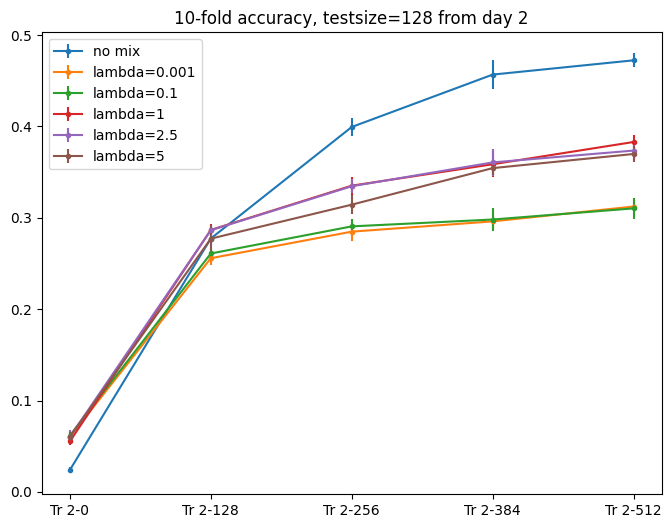

<Figure size 640x480 with 0 Axes>

In [ ]:
"""Visualize the mix prediction (classifier) learning curves"""

# give the filepaths to read-in if you want learning curve visualizer to read data from files
filepaths = np.array([r"F:\RiceStudy\BCI\log\0417_learningcurve_only2.xlsx",\
             r"F:\RiceStudy\BCI\log\0417_learningcurve_1n2_001.xlsx",\
             r"F:\RiceStudy\BCI\log\0417_learningcurve_1n2_01.xlsx",\
             r"F:\RiceStudy\BCI\log\0417_learningcurve_1n2_1.xlsx",\
             r"F:\RiceStudy\BCI\log\0417_learningcurve_1n2_2p5.xlsx",\
                r"F:\RiceStudy\BCI\log\0417_learningcurve_1n2_5.xlsx"])

file_read = False
if file_read:
    results = filepaths
else:
    reults = accuracies
output = r"F:\RiceStudy\BCI\log\0417_learningcurves.png"
cases = ["no mix", "lambda=0.001", "lambda=0.1", "lambda=0.5", "lambda=1", "lambda=5", "lambda=10"]
title = "10-fold accuracy, testsize=128 from day 2"
trials = ["Tr 2-0", "Tr 2-128", "Tr 2-256", "Tr 2-384", "Tr 2-512"]

xtk = [range(len(trials)), trials]
lvisu.learning_curves(results, output, cases, title, xtk)

try: # delete the name of accuracies for the next time's examination
    del accuracies
    gc.collect()
except NameError:
    pass